# Interpolation, imputation, and resampling

This notebook will take us through a basic overview of approaches to dealing with missing data (interpolation and imputation) and resampling (usually for dealing with age models for time series).  As with most things in Python, there are multiple ways to approach these issues and functions or classes spread across multiple libraries.  We'll look at a few of the primary methods and libraries here.

First, let's get our libraries.

In [1]:
import math
import numpy as np 
import scipy as sp
import pandas as pd 
import matplotlib.pyplot as plt 

# switch font default to Helvetica
# plt.rcParams['font.family'] = 'Helvetica'

We're going to create a simulated time series again (as before) using a sine wave.  It is important to note, however, that different series and different patterns of missing data may be more ameniable to a set of different approaches to interpolation (or imputation).  Here we'll see ones that work well, and others that are less successful in reproducing the underlying function. 

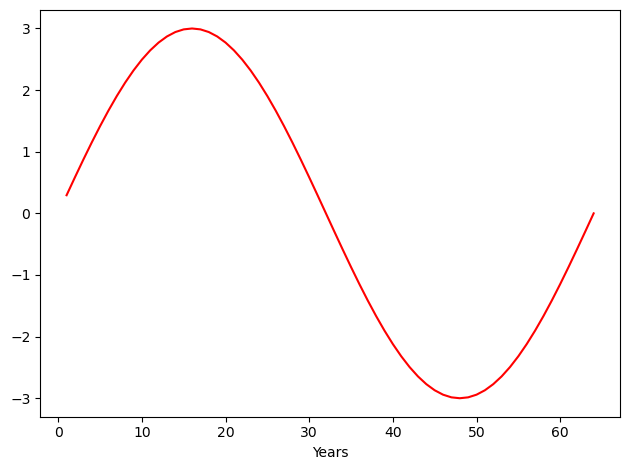

In [2]:
# we'll use 64 time points 
n_samples = 64

# Create our time vector - e.g. 64 years long
t = np.arange(1, n_samples+1)

# Create a sine wave with frequency set to the variable cycles_per_time 
cycles_per_time = 2
cycle_amplitude = 3 
u = 2 * np.pi * (cycles_per_time/128) * t

# here is our simulated time seres
st = cycle_amplitude * np.sin(u)
    
# Plot the simulated noise-free time series
plt.figure()
plt.plot(t, st, 'r')
plt.xlabel('Years')
plt.tight_layout()

We'll now remove some of the data from the series above and attempt to interpolate or impute it, comparing the result to the known underlying function we created.  

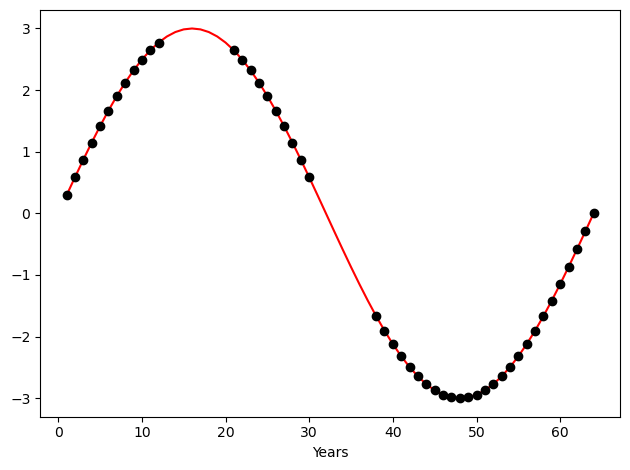

In [4]:
# create a copy using Numpy of st that we can remove some data from
stm = st.copy()

# remove two chunks of data from stm and replace with NaNs
stm[12:20] = np.nan
stm[30:37] = np.nan

# Plot the original time series and the stm series with NaN values
plt.figure()
plt.plot(t, st, 'r-')
plt.plot(t, stm, 'ko')
plt.xlabel('Years')
plt.tight_layout()

### Using Numpy

Numpy has a simple linear interpolation module ([np.interp](https://numpy.org/doc/stable/reference/generated/numpy.interp.html)).  It takes the independent variable (which we might call the x-coordinate or the x-axis, which for us will frequently be the 'time' dimension of some sort) and the x- and y-axis values for which there are data, and returns interpolated values for all the x-axis locations.  The x-axis coordinate (as well as those x-axis coordinates with valid data) is expected to be increasing.  Here's an example, applied to our simulated missing data series:

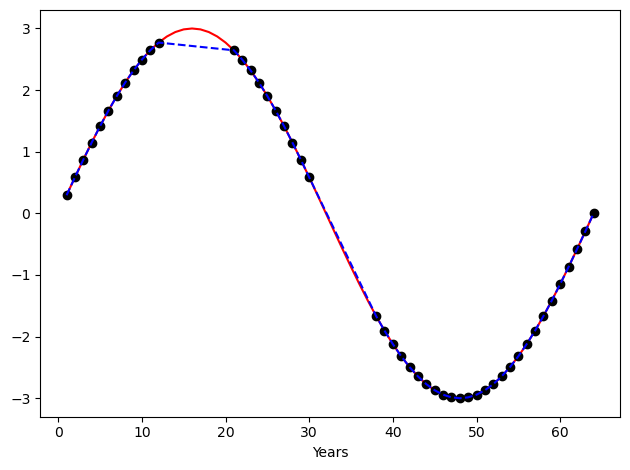

In [6]:
# index of the values of stm that are NOT NaNs
valid = ~np.isnan(stm)

# interpolation
stm_linear = np.interp(t, t[valid], stm[valid])

# Plot original, original with missing, and interpolation
plt.figure()
plt.plot(t, st, 'r-')
plt.plot(t, stm, 'ko')
plt.plot(t, stm_linear, 'b--')
plt.xlabel('Years')
plt.tight_layout()

Linear interpolation (however applied) does OK here during linear parts of the function, but can't reproduce the curved crest of the sine wave, not surprisingly.

### Using Scipy

Scipy has a [much more extensive set of interpolation tools](https://docs.scipy.org/doc/scipy/reference/interpolate.html) -- indeed, an entire sub-package of them.  These include a wide variety of different functions that can be applied to missing data estimation.  A commonly used function is [interp1d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d), although note that this is now a legacy function whose operations are now meant to be taken up by different more specific functions.  `interp1d` gives you many options for the kind of interpolation you can do - ‘linear’, ‘nearest’, ‘nearest-up’, ‘zero’, ‘slinear’, ‘quadratic’, ‘cubic’, ‘previous’, or ‘next’. The options ‘zero’, ‘slinear’, ‘quadratic’ and ‘cubic’ all refer to [splines](https://en.wikipedia.org/wiki/Spline_interpolation) of increasing orders (0th order to 3rd order).  

As with other sub-packages in Scipy, interpolation actually takes two steps.  First, you construt the interpolator (here using `interp1d`) and then apply the interpolator you created to the x-coordinate.  `interp1d` also accepts a input option for `fill_value`, which tells Scipy what to do for values outside the data range (e.g. at the end of series, for instance).  

Let's look at a few examples using `interp1d` specifically:

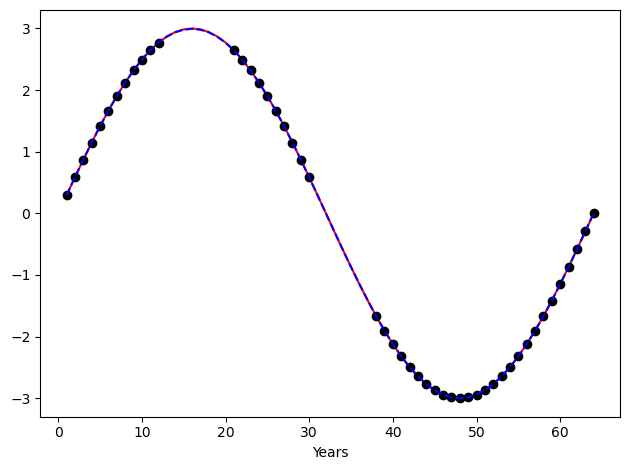

In [13]:
from scipy.interpolate import interp1d

# index to non NaN values in the y-coordinate
valid = ~np.isnan(stm)

# create the interpolator, specifying a cubic spline and extrapolation if necessary 
cubic_interpolator = interp1d(t[valid], stm[valid], kind='cubic', fill_value="extrapolate") # Builds the interpolator (can use 'linear', 'nearest', 'cubic', 'quadratic', and others) 

# call the interpolator by passing it all of the x-coordinate 
stm_cubic = cubic_interpolator(t) # give the time vector to the interpolator

# Plot original, original with missing, and interpolation
plt.figure()
plt.plot(t, st, 'r-')
plt.plot(t, stm, 'ko')
plt.plot(t, stm_cubic, 'b--')
plt.xlabel('Years')
plt.tight_layout()


You can see the cubic spline is a good choice for our particular time series and the pattern of missingness, as it can follow the curve of the sine wave crest.  We can see if a different flexible curve does as well, applying now the 'quadratic' method:



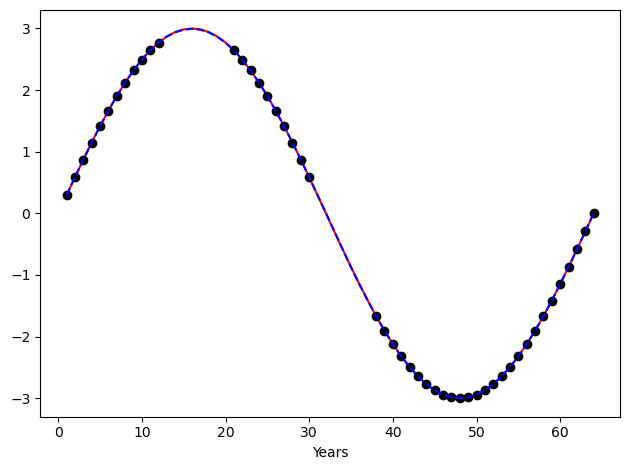

In [15]:
# create the interpolator, specifying a cubic spline and extrapolation if necessary 
quadratic_interpolator = interp1d(t[valid], stm[valid], kind='quadratic', fill_value="extrapolate") # Builds the interpolator (can use 'linear', 'nearest', 'cubic', 'quadratic', and others) 

# call the interpolator by passing it all of the x-coordinate 
stm_quadratic = quadratic_interpolator(t) # give the time vector to the interpolator

# Plot original, original with missing, and interpolation
plt.figure()
plt.plot(t, st, 'r-')
plt.plot(t, stm, 'ko')
plt.plot(t, stm_quadratic, 'b--')
plt.xlabel('Years')
plt.tight_layout()

The quadratic spline also does a good job. 

As `interp1d` is now deprecated, we should also look at the newer way of calling different interpolation functions by importing the specific interpolator classes.  Here we'll see the way to import the `pchip` (Piecewise Cubic Hermite Interpolating Polynomial) class and apply it to our missing data series

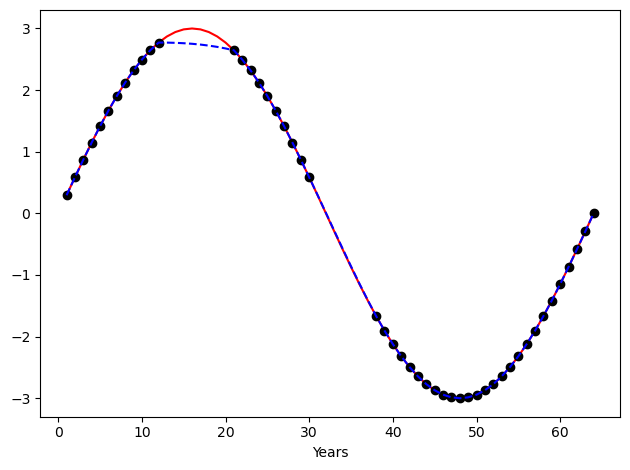

In [19]:
from scipy.interpolate import PchipInterpolator

pchip_interpolator = PchipInterpolator(t[valid], stm[valid])

stm_pchip = pchip_interpolator(t)

# Plot original, original with missing, and interpolation
plt.figure()
plt.plot(t, st, 'r-')
plt.plot(t, stm, 'ko')
plt.plot(t, stm_pchip, 'b--')
plt.xlabel('Years')
plt.tight_layout()


We can see the PCHIP approach is not as good as the spline here, as it fails to reproduce the crest of the waveform from the original data. 

### Interpolating in Pandas DataFrames or DataSeries

Pandas contains its own [interpolation function](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html), but behind the scenes is [using Scipy](https://docs.scipy.org/doc/scipy/reference/interpolate.html#univariate-interpolation).  For DataFrames, you can decide which dimension to apply the interpolation (row-wise or column-wise), whereas for a DataSeries the interpolation is just on the available dimension. The interpolation function in Pandas accepts very similar methods to Scipy, not surprisingly, but is also capable of understanding the index as a time variable and acting accordingly. 

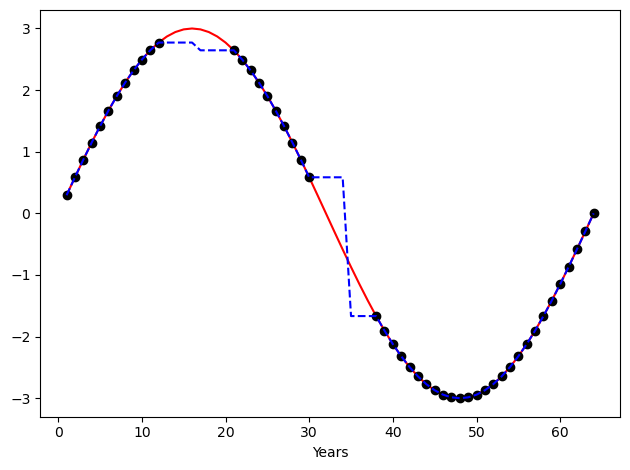

In [23]:
# Convert the NumPy array to a pandas Series 
stm_series = pd.Series(stm)

# call the Nearest neighbor interpolation directly on the DataSeries
stm_nearest_pd = stm_series.interpolate(method='nearest') # others to try: ‘barycentric’, ‘polynomial’ 

# Plot original, original with missing, and interpolation
plt.figure()
plt.plot(t, st, 'r-')
plt.plot(t, stm, 'ko')
plt.plot(t, stm_nearest_pd, 'b--')

plt.xlabel('Years')
plt.tight_layout()

Nearest neighbor type approaches are probably reasonable for missing-at-random points, but for multiple missing values in a strongly structured function like the sine wave, the results are not as good as a spline fits. 

### Imputation in scikit-learn

scikit-learn contains [several approaches to imputation](https://scikit-learn.org/1.5/modules/impute.html) - or replacing missing values with some other (hopefully reasonable values). The [`SimpleImputer`](https://scikit-learn.org/1.5/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer) largely replaces missing values with things like the mean, median, a constant, or most frequent value.  These are reasonable choices for some patterns of missing data, depending on the underlying structure of the data and how randomly the data are missing and what the ultimate purpose of the missing value replacement is for your inference.  Other datasets might require something more sophistocated.  The [`IterativeImputer`](https://scikit-learn.org/1.5/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer) allows you to specify a wide range of estimators from scikit-learn.  Here's just one example, using a Random Forest regression approach on our missing data series from above:


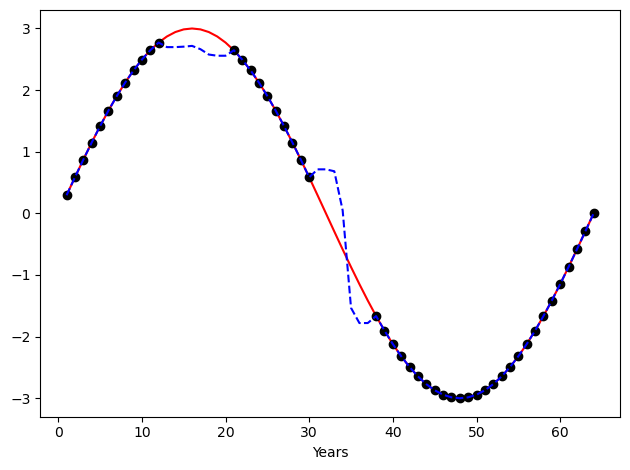

In [28]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared
from sklearn.ensemble import RandomForestRegressor

# combine our data into a single variable
data_combined = np.column_stack((t, stm.reshape(-1, 1)))  

# set the estimator
estimator = RandomForestRegressor(warm_start=True)

# Initialize the IterativeImputer.
imputer = IterativeImputer(estimator=estimator,max_iter=100)

# Fit the imputer on the data and transform it to fill in missing values.
stm_imputed = imputer.fit_transform(data_combined)

# Plot original, original with missing, and interpolation
plt.figure()
plt.plot(t, st, 'r-')
plt.plot(t, stm, 'ko')
plt.plot(stm_imputed[:,0], stm_imputed[:,1], 'b--')

plt.xlabel('Years')
plt.tight_layout()

There is a lot of potential to use scikit-learn for sophisticated imputation approaches - see here: https://scikit-learn.org/1.5/modules/impute.html 

## Resampling

Resampling is related to interpolation in that we seek to put our y-values on a different set of x-coordinates, usually based on interpolation as we did above for missing values.  We could understand the new set of x-coordinates as including 'missing' locations on the x-axis of our series or function.  A frequent use of resampling is to place a time series on a different time base - perhaps higher or lower resolution (upscaling or downscaling) or making an irregularly observed process into one with a consistent time step (for the paleoclimatologists in the room, especially those using time-uncertain records, you might do this before using spectral analysis, for instance).

Here's I'll demonstrate this on the [~800,000 CO2 record from Antarctic ice cores].   The full citation for these data is:

> Bernhard Bereiter, Sarah Eggleston, Jochen Schmitt, Christoph Nehrbass-Ahles, Thomas F. Stocker, Hubertus Fischer, Sepp Kipfstuhl and Jerome Chappellaz. 2015. Revision of the EPICA Dome C CO2 record from 800 to 600 kyr before present. *Geophysical Research Letters*, doi: 10.1002/2014GL061957 

We'll use Pandas to read in the data, extract the temporal data (which is in calibrated years Before Present (BP), which actually means years before 1950), make some diagnostic plots, and then interpolate the age model to a regular time step of 100 years. 

Text(0, 0.5, '$CO_{2}$ (ppm)')

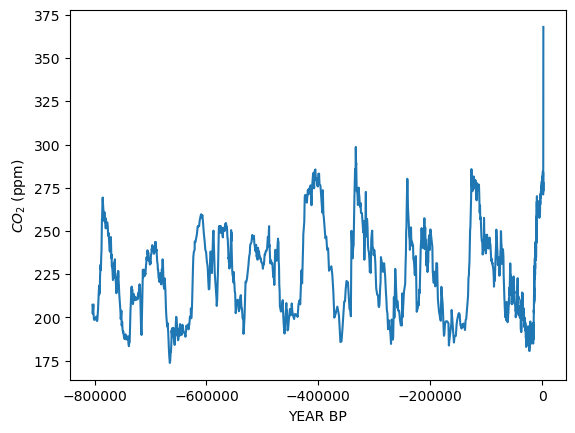

In [59]:
# let's get the ice core time series
df = pd.read_csv('co2composite.csv') # this line use Pandas to read in the CSV file.  You might need to change the path to the file

# let's extract the columns we want
co2 = np.asarray(df["co2_ppm"])
ice_age = df["age_gas_calBP"] # this is in calibrated years BP, which means years before 1950

# let's plot the data
plt.plot(1950-ice_age,co2)
plt.xticks(np.linspace(-800000,0,5))
plt.xlabel('YEAR BP')
plt.ylabel('$CO_{2}$ (ppm)')

With a histogram, we can see the range of different time-steps between the CO2 data points:

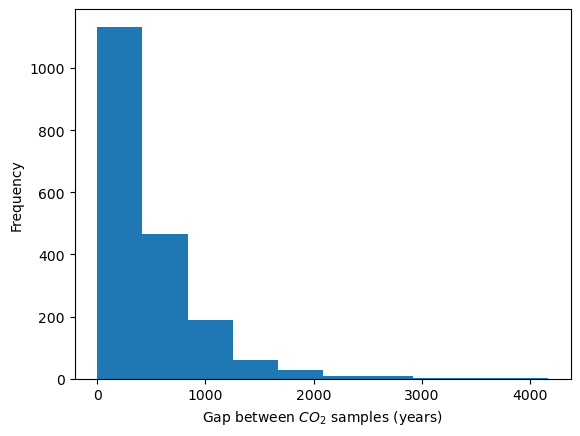

In [62]:
# make a histogram of the difference between each age
plt.hist(np.diff(ice_age));
plt.xlabel('Gap between $CO_2$ samples (years)');
plt.ylabel('Frequency');

The time steps range from <100 years to many thousands of years.  It would be a challenge to do the type of spectral analysis we've done in class on these data.  But we can use `interp1d` again to place these CO2 data on a regular time step:

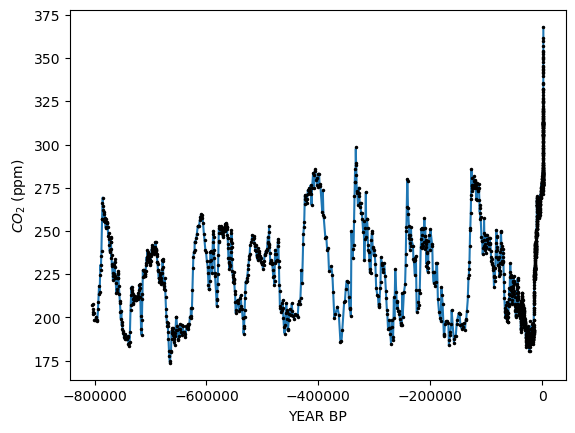

In [65]:
# this next call to interpolate creates the function (f) which will do the interpolation for us
resampler = interp1d(ice_age, co2) # we'll use f to put CO2 on a new age scale
age_new = np.arange(-51, 800000, 100) # let's put the ice core on 100 year spacing
co2_new = resampler(age_new) # using the interpolate function f we created before, apply the new ages to the CO2 series

# ... and let's plot to make sure everything looks OK
plt.plot(1950-age_new,co2_new) # interpolated data
plt.plot(1950-ice_age,co2,'k.',markersize=3) # original data
plt.xticks(np.linspace(-800000,0,5));
plt.xlabel('YEAR BP');
plt.ylabel('$CO_{2}$ (ppm)');

We can see now that all the time steps are the same:

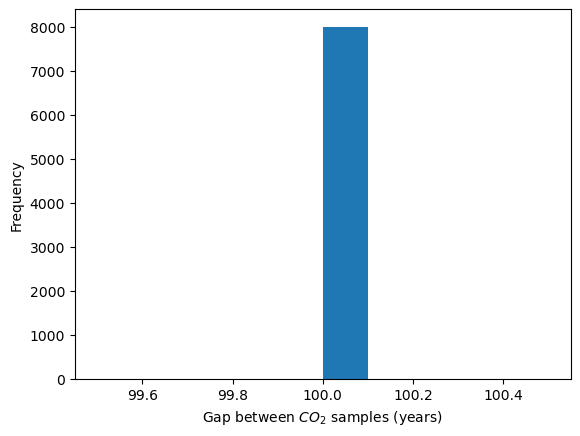

In [67]:
# make a histogram of the difference between each age
plt.hist(np.diff(age_new));
plt.xlabel('Gap between $CO_2$ samples (years)');
plt.ylabel('Frequency');

## Next Steps

1. Try to create a more complex curve (e.g. the sum of different sine and cosines) with missing values and see how different interpolation methods do at a more challenging target
2. Try and create white or red noise curve without the regular structure of a sine or cosine - which methods seem to work best in this case? 
3. Perform MTM spectral analysis on the resampled CO2 data, above.  Try different interpolations (e.g. non-linear, different time steps in the new age model) - can you detect any consequences of the resampling choices in the spectrum for this particular time series?  How generalizable do you think this observation might be? 